# Part 3: MNIST RNN
## 3a: Setup an RNN: 
> With a CNN, we would send in full images, yet with the RNN, inputs to the network are 28 pixel chunks of the images. For example, each row of the  image will be sent to the network at each iteration. Use the starter code provided on the Canvas assignment page (assignment 2 part 2 rnn mnist skeleton.py) to implement a RNN model on the MNIST dataset like in Assignment 1.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
# -*- coding: utf-8 -*-
"""Assignment_2_Part_2_RNN_MNIST_vp1.ipynb
Overall structure:

1) Set Pytorch metada
- seed
- tensorflow output
- whether to transfer to gpu (cuda)

2) Import data
- download data
- create data loaders with batchsie, transforms, scaling

3) Define Model architecture, loss and optimizer

4) Define Test and Training loop
    - Train:
        a. get next batch
        b. forward pass through model
        c. calculate loss
        d. backward pass from loss (calculates the gradient for each parameter)
        e. optimizer: performs weight updates

5) Perform Training over multiple epochs:
    Each epoch:
    - call train loop
    - call test loop

# Step 1: Pytorch and Training Metadata
"""
0

0

In [7]:

try_cuda = True
seed = 1000
logging_interval = 10 # how many batches to wait before logging
logging_dir = None
input_size = 28
batch_size = 64
test_batch_size = 1000

# 1) setting up the logging

datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')

if logging_dir is None:
    runs_dir = Path("./") / Path(f"runs/")
    runs_dir.mkdir(exist_ok = True)

    logging_dir = runs_dir / Path(f"{datetime_str}")

    logging_dir.mkdir(exist_ok = True)
    logging_dir = str(logging_dir.absolute())

writer = SummaryWriter(log_dir=logging_dir)

#deciding whether to send to the cpu or not if available
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.manual_seed(seed)
else:
    cuda = False
    torch.manual_seed(seed)

C:\Users\kdmen\miniconda3\envs\dl\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\kdmen\miniconda3\envs\dl\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


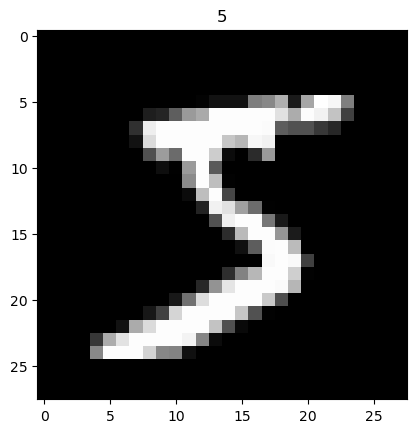

In [5]:
"""# Step 2: Data Setup"""

# Setting up data
#transform=[insert-code: create transforms]
#train_dataset = [insert-code: download and transform cifar10 training data]
#test_dataset = [insert-code: download and transform cifar10 test data]
#train_loader = [insert-code: create train data loader]
#test_loader = [insert-code: create test data loader]
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor(),  # Converts to torch.FloatTensor 
    transforms.Normalize((0.5,), (0.5,))  # Scale values
])
# Download MNIST dataset (<datasets> is from torchvision)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Set up train/test loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# plot one example
print(train_dataset.train_data.size())     # (60000, 28, 28)
print(train_dataset.train_labels.size())   # (60000)
plt.imshow(train_dataset.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_dataset.train_labels[0])
plt.show()



In [9]:
"""# Step 3: Creating the Model"""

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_type='rnn', num_layers=1):
        super(Net, self).__init__()

        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        elif rnn_type == 'rnn':
            self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        else:
            raise ValueError("Invalid RNN type. Choose 'lstm', 'rnn', or 'gru'.")

        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, hidden = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])
        return out

model = Net(input_size=input_size, hidden_size=64, output_size=10, rnn_type='rnn', num_layers=1)

if cuda:
    model.cuda()

In [18]:
#optimizer = [insert-code: USE AN ADAM OPTIMIZER]
epochs = 10
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr) 

In [15]:
"""# Step 4: Train/Test"""

# Defining the test and trainig loops

def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda() 
            
        data = data.view(-1, 28, 28)  # Reshape the data to (batch_size, sequence_length, input_size)

        optimizer.zero_grad()
        output = model(data)  # forward
        loss = criterion(output, target)
        #[insert-code: implement training loop with logging]
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    # Log training statistics
    print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
              f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    # Calculate and log average training loss and accuracy
    avg_loss = train_loss / len(train_loader)
    accuracy = correct / total
    print(f'Train Epoch: {epoch}\tAverage Loss: {avg_loss:.6f}\tAccuracy: {100 * accuracy:.2f}%')
    return avg_loss, accuracy
    

def test(epoch):
    #[insert-code: implement testing loop with logging]
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if cuda:
                data, target = data.cuda(), target.cuda()

            data = data.view(-1, 28, 28)

            output = model(data)
            loss = criterion(output, target)

            # Update test loss
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    # Calculate and log average test loss and accuracy
    avg_loss = test_loss / len(test_loader)
    accuracy = correct / total
    print(f'Test Epoch: {epoch}\tAverage Loss: {avg_loss:.6f}\tAccuracy: {100 * accuracy:.2f}%')
    return avg_loss, accuracy

In [19]:
# Training loop
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_loss, train_accuracy = train(epoch)
    test_loss, test_accuracy = test(epoch)

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)  
    print()
        
#[insert-code: running test and training over epoch]
writer.close()

# Commented out IPython magic to ensure Python compatibility.
"""
#https://stackoverflow.com/questions/55970686/tensorboard-not-found-as-magic-function-in-jupyter

#seems to be working in firefox when not working in Google Chrome when running in Colab
#https://stackoverflow.com/questions/64218755/getting-error-403-in-google-colab-with-tensorboard-with-firefox


# %load_ext tensorboard
# %tensorboard --logdir [dir]

"""
0

Epoch 1 of 10
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.076576
Train Epoch: 0	Average Loss: 0.134206	Accuracy: 96.13%
Test Epoch: 0	Average Loss: 0.136887	Accuracy: 95.89%

Epoch 2 of 10
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.008632
Train Epoch: 1	Average Loss: 0.128655	Accuracy: 96.27%
Test Epoch: 1	Average Loss: 0.122412	Accuracy: 96.37%

Epoch 3 of 10
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.141631
Train Epoch: 2	Average Loss: 0.132384	Accuracy: 96.19%
Test Epoch: 2	Average Loss: 0.120127	Accuracy: 96.44%

Epoch 4 of 10
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.026969
Train Epoch: 3	Average Loss: 0.125404	Accuracy: 96.26%
Test Epoch: 3	Average Loss: 0.134900	Accuracy: 96.25%

Epoch 5 of 10
Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.075345
Train Epoch: 4	Average Loss: 0.164924	Accuracy: 95.06%
Test Epoch: 4	Average Loss: 0.172782	Accuracy: 94.70%

Epoch 6 of 10
Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.073734
Train Epoch: 5	Average Loss: 0.151485	Accuracy: 95.43%
Test 

0

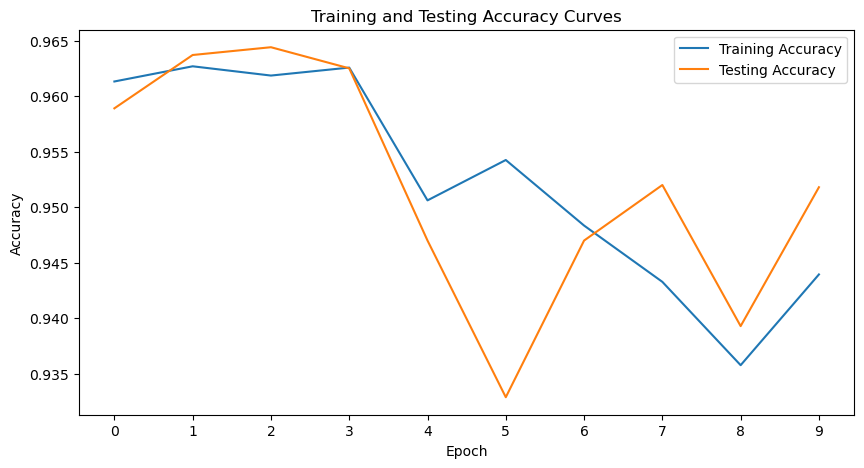

In [20]:
# Plotting accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(test_accuracy_list, label='Testing Accuracy')
plt.xticks(range(epochs))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy Curves')
plt.show()

You should modify the following parameters to test how the model differs in performance.
- Number of nodes in the hidden layer
- Learning rate
- Number of iterations
- Optimizer

> Defaults: hidden_size=64, num_layers=1, lr=1e-2, ADAM

> I only train for 4 epochs, so am looking for a quick uptick in performance for the hyperparameter tuning, less interested in the full training curve 

In [ ]:
def short_hyperparam_run2(num_hidden_units, num_layers, opt_str, learning_rate, rnn_type, epochs=3, input_momentum=0.9, rmsprop_dampening=0.9, l2_wd=1e-4, use_scheduler=False):

    # Input size of 28, output size of 10 are fixed
    model = Net(input_size=28, hidden_size=num_hidden_units, output_size=10, rnn_type=rnn_type, num_layers=num_layers)

    if opt_str.upper() == 'ADAM':
        print("ADAM does not use momentum as a parameter\n")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_wd) 
    elif opt_str.upper() == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=input_momentum, weight_decay=l2_wd) 
    elif opt_str.upper() == 'ADAGRAD':
        print("ADAGRAD does not use momentum as a parameter\n")
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=l2_wd) 
    elif opt_str.upper() == 'NADAM':
        optimizer = optim.Nadam(model.parameters(), lr=learning_rate, momentum=input_momentum, weight_decay=l2_wd)
    elif opt_str.upper() == 'RMSPROP':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=input_momentum, weight_decay=l2_wd) #dampening=rmsprop_dampening, 
    else:
        raise ValueError('Optimizer not defined')

    if use_scheduler:
        scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    train_loss_list = []
    train_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1} of {epochs}")
        train_loss, train_accuracy = train(epoch)
        test_loss, test_accuracy = test(epoch)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)  
        print()

    # Plotting accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy_list, label='Training Accuracy')
    plt.plot(test_accuracy_list, label='Testing Accuracy')
    plt.xticks(range(epochs))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Testing Accuracy Curves')
    plt.show()

- 7 hidden units
- ADAM
- lr = 1e-3

ADAM does not use momentum as a parameter

Epoch 1 of 4
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.301915
Train Epoch: 0	Average Loss: 0.157344	Accuracy: 95.34%
Test Epoch: 0	Average Loss: 0.140859	Accuracy: 95.66%

Epoch 2 of 4
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.161667
Train Epoch: 1	Average Loss: 0.163405	Accuracy: 95.19%
Test Epoch: 1	Average Loss: 0.163849	Accuracy: 95.36%

Epoch 3 of 4
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.140017
Train Epoch: 2	Average Loss: 0.168767	Accuracy: 95.03%
Test Epoch: 2	Average Loss: 0.216236	Accuracy: 93.54%

Epoch 4 of 4
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.075587
Train Epoch: 3	Average Loss: 0.163636	Accuracy: 95.17%
Test Epoch: 3	Average Loss: 0.191815	Accuracy: 94.32%



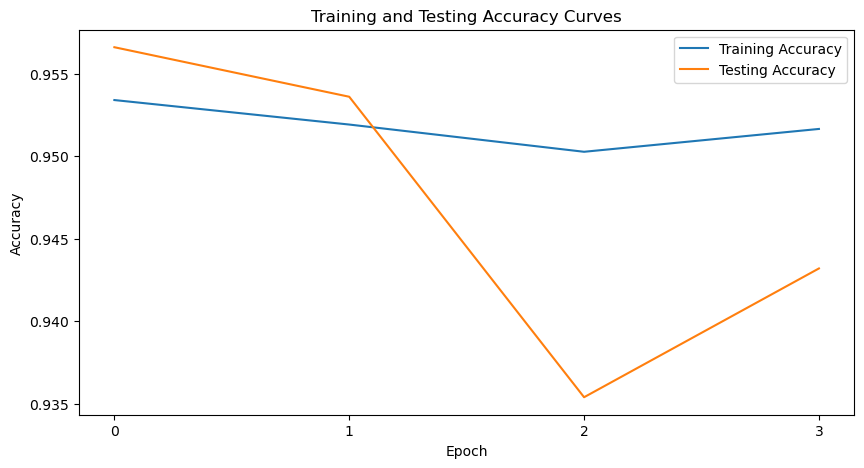

In [23]:
short_hyperparam_run2(num_hidden_units=7, num_layers=1, opt_str='ADAM', rnn_type='rnn', learning_rate=1e-3, epochs=4)

- 7 hidden units
- ADAGRAD
- lr = 1e-3

ADAGRAD does not use momentum as a parameter

Epoch 1 of 4
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.167512
Train Epoch: 0	Average Loss: 0.227491	Accuracy: 93.24%
Test Epoch: 0	Average Loss: 0.170131	Accuracy: 94.87%

Epoch 2 of 4
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.096327
Train Epoch: 1	Average Loss: 0.166177	Accuracy: 95.08%
Test Epoch: 1	Average Loss: 0.137617	Accuracy: 96.04%

Epoch 3 of 4
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.166483
Train Epoch: 2	Average Loss: 0.155807	Accuracy: 95.41%
Test Epoch: 2	Average Loss: 0.163635	Accuracy: 95.25%

Epoch 4 of 4
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.036595
Train Epoch: 3	Average Loss: 0.221665	Accuracy: 93.35%
Test Epoch: 3	Average Loss: 0.263892	Accuracy: 91.75%



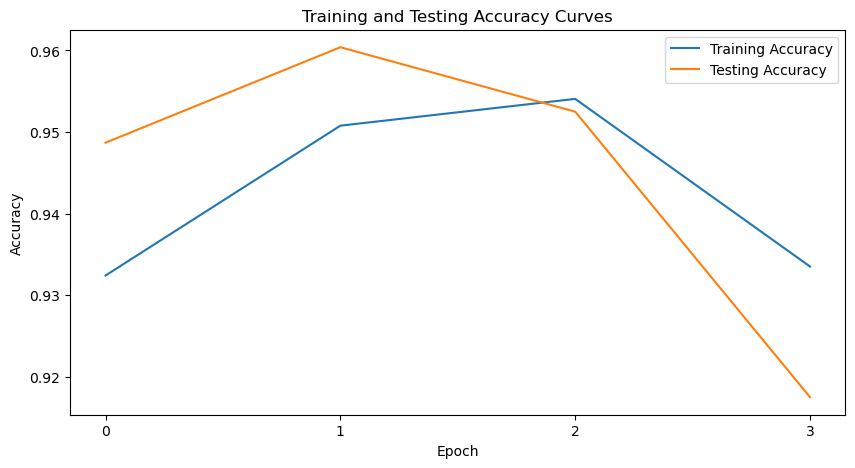

In [24]:
short_hyperparam_run2(num_hidden_units=7, num_layers=1, opt_str='ADAGRAD', rnn_type='rnn', learning_rate=1e-3, epochs=4)

- 7 hidden units
- RMSPROP
- lr = 1e-3

Epoch 1 of 4
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.174161
Train Epoch: 0	Average Loss: 0.196840	Accuracy: 94.19%
Test Epoch: 0	Average Loss: 0.148462	Accuracy: 95.50%

Epoch 2 of 4
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.337404
Train Epoch: 1	Average Loss: 0.166937	Accuracy: 95.22%
Test Epoch: 1	Average Loss: 0.175005	Accuracy: 94.82%

Epoch 3 of 4
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.081907
Train Epoch: 2	Average Loss: 0.174884	Accuracy: 94.73%
Test Epoch: 2	Average Loss: 0.217540	Accuracy: 93.56%

Epoch 4 of 4
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.526151
Train Epoch: 3	Average Loss: 0.266246	Accuracy: 91.73%
Test Epoch: 3	Average Loss: 0.272430	Accuracy: 91.73%



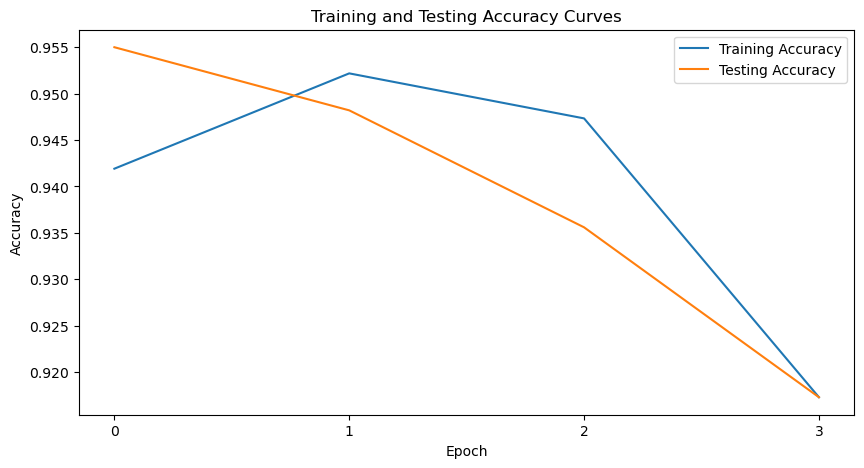

In [25]:
short_hyperparam_run2(num_hidden_units=7, num_layers=1, opt_str='RMSPROP', rnn_type='rnn', learning_rate=1e-3, epochs=4)

## Invetigating Num Hidden Units 
> Using ADAM since it appears to be the best

- 25 hidden units
- ADAM
- lr = 1e-3

ADAM does not use momentum as a parameter

Epoch 1 of 4
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.192555
Train Epoch: 0	Average Loss: 0.213235	Accuracy: 93.55%
Test Epoch: 0	Average Loss: 0.192744	Accuracy: 94.00%

Epoch 2 of 4
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.155212
Train Epoch: 1	Average Loss: 0.176095	Accuracy: 94.72%
Test Epoch: 1	Average Loss: 0.141586	Accuracy: 95.66%

Epoch 3 of 4
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.329700
Train Epoch: 2	Average Loss: 0.150546	Accuracy: 95.53%
Test Epoch: 2	Average Loss: 0.165464	Accuracy: 95.32%

Epoch 4 of 4
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.539917
Train Epoch: 3	Average Loss: 0.195663	Accuracy: 94.21%
Test Epoch: 3	Average Loss: 0.248343	Accuracy: 92.69%



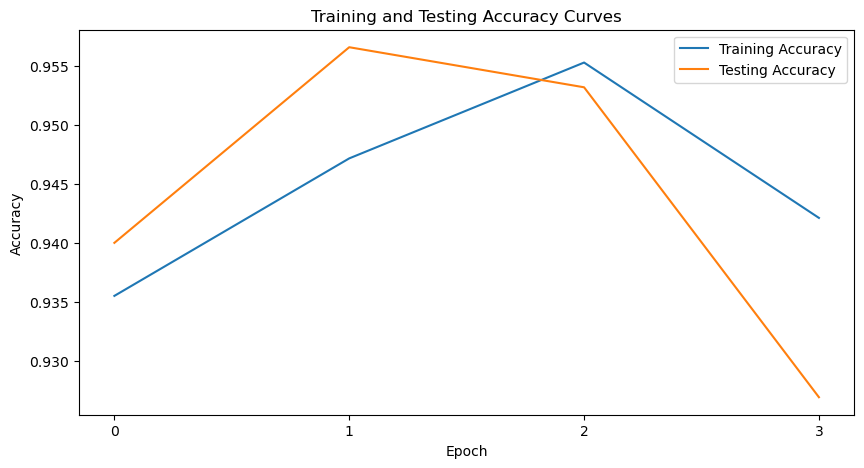

In [26]:
short_hyperparam_run2(num_hidden_units=25, num_layers=1, opt_str='ADAM', rnn_type='rnn', learning_rate=1e-3, epochs=4)

- 3 hidden units
- ADAM
- lr = 1e-3

ADAM does not use momentum as a parameter

Epoch 1 of 4
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.795638
Train Epoch: 0	Average Loss: 0.491807	Accuracy: 84.92%
Test Epoch: 0	Average Loss: 0.433985	Accuracy: 86.72%

Epoch 2 of 4
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.304895
Train Epoch: 1	Average Loss: 0.355753	Accuracy: 89.29%
Test Epoch: 1	Average Loss: 0.270673	Accuracy: 92.15%

Epoch 3 of 4
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.132386
Train Epoch: 2	Average Loss: 0.286995	Accuracy: 91.39%
Test Epoch: 2	Average Loss: 0.286301	Accuracy: 91.20%

Epoch 4 of 4
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.365673
Train Epoch: 3	Average Loss: 0.308988	Accuracy: 90.59%
Test Epoch: 3	Average Loss: 0.296690	Accuracy: 90.79%



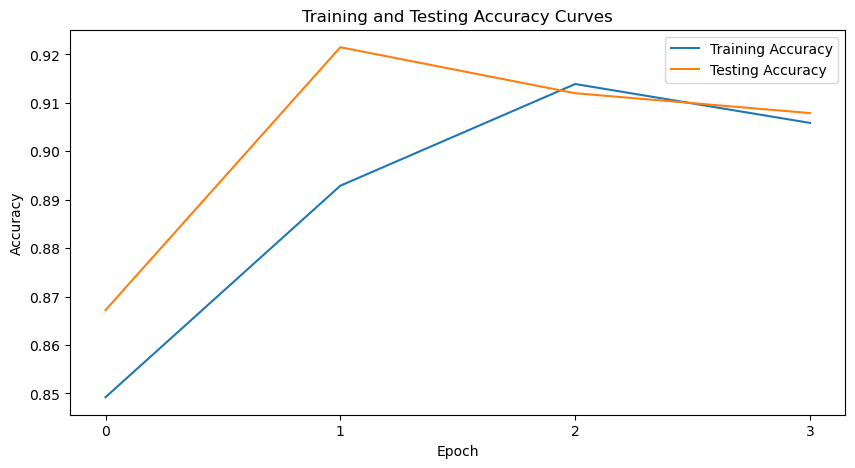

In [27]:
short_hyperparam_run2(num_hidden_units=3, num_layers=1, opt_str='ADAM', rnn_type='rnn', learning_rate=1e-3, epochs=4)

## Investigating Learning Rate
> Using ADAM and 64 hidden units
- 64 hidden units
- ADAM
- lr = 1e-4

ADAM does not use momentum as a parameter

Epoch 1 of 4
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.337054
Train Epoch: 0	Average Loss: 0.271901	Accuracy: 91.82%
Test Epoch: 0	Average Loss: 0.226988	Accuracy: 93.53%

Epoch 2 of 4
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.577252
Train Epoch: 1	Average Loss: 0.335221	Accuracy: 89.80%
Test Epoch: 1	Average Loss: 0.635289	Accuracy: 81.04%

Epoch 3 of 4
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.383491
Train Epoch: 2	Average Loss: 0.449696	Accuracy: 86.15%
Test Epoch: 2	Average Loss: 0.312156	Accuracy: 90.65%

Epoch 4 of 4
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.393798
Train Epoch: 3	Average Loss: 0.442091	Accuracy: 86.41%
Test Epoch: 3	Average Loss: 0.729910	Accuracy: 77.54%



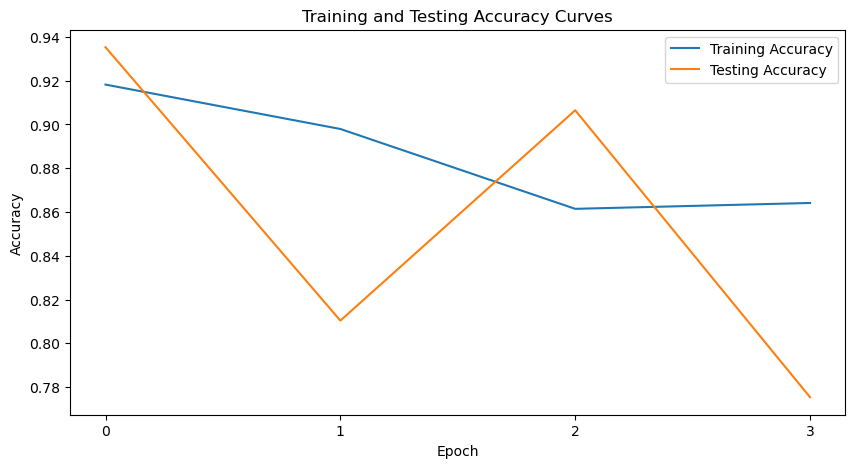

In [28]:
short_hyperparam_run2(num_hidden_units=64, num_layers=1, opt_str='ADAM', rnn_type='rnn', learning_rate=1e-4, epochs=4)

- 64 hidden units
- ADAM
- lr = 1e-2

ADAM does not use momentum as a parameter

Epoch 1 of 4
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.244673
Train Epoch: 0	Average Loss: 0.475501	Accuracy: 85.41%
Test Epoch: 0	Average Loss: 0.347449	Accuracy: 89.37%

Epoch 2 of 4
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.561576
Train Epoch: 1	Average Loss: 0.325285	Accuracy: 89.98%
Test Epoch: 1	Average Loss: 0.322444	Accuracy: 90.14%

Epoch 3 of 4
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.446603
Train Epoch: 2	Average Loss: 0.297056	Accuracy: 91.02%
Test Epoch: 2	Average Loss: 0.274155	Accuracy: 91.75%

Epoch 4 of 4
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.397552
Train Epoch: 3	Average Loss: 0.401204	Accuracy: 87.55%
Test Epoch: 3	Average Loss: 0.327098	Accuracy: 89.66%



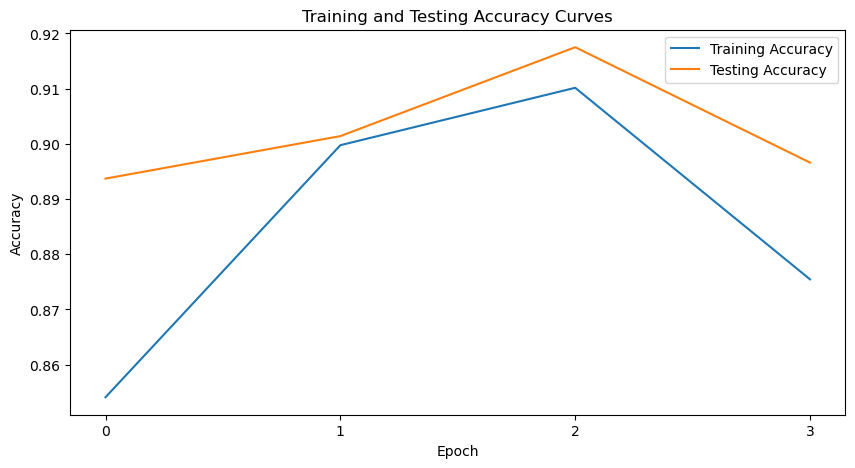

In [29]:
short_hyperparam_run2(num_hidden_units=64, num_layers=1, opt_str='ADAM', rnn_type='rnn', learning_rate=1e-2, epochs=4)

> __Conclusion:__ The best set of params is ADAM, 64 hidden units, and a learing rate of 1e-3

## 3b: How about using an LSTM or GRU
> Change the starter code to use LSTM and GRU instead of RNN (hint: this should be a very easy modular change to a couple lines of code if you are doing it right).

ADAM does not use momentum as a parameter

Epoch 1 of 8
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.309310
Train Epoch: 0	Average Loss: 0.541417	Accuracy: 83.17%
Test Epoch: 0	Average Loss: 0.531701	Accuracy: 83.75%

Epoch 2 of 8
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.380934
Train Epoch: 1	Average Loss: 0.532256	Accuracy: 83.53%
Test Epoch: 1	Average Loss: 0.432438	Accuracy: 86.58%

Epoch 3 of 8
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.628339
Train Epoch: 2	Average Loss: 0.423436	Accuracy: 87.08%
Test Epoch: 2	Average Loss: 0.356204	Accuracy: 88.86%

Epoch 4 of 8
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.591222
Train Epoch: 3	Average Loss: 0.398678	Accuracy: 87.89%
Test Epoch: 3	Average Loss: 0.427306	Accuracy: 86.51%

Epoch 5 of 8
Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.569244
Train Epoch: 4	Average Loss: 0.435528	Accuracy: 86.71%
Test Epoch: 4	Average Loss: 0.383965	Accuracy: 87.91%

Epoch 6 of 8
Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.088871
Train Epoch: 5	Average 

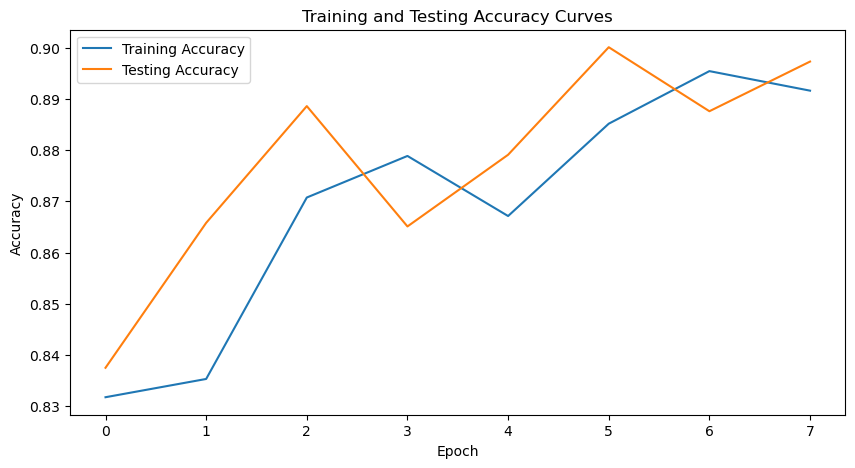

In [41]:
short_hyperparam_run2(num_hidden_units=64, num_layers=1, opt_str='ADAM', rnn_type='lstm', learning_rate=1e-3, epochs=8)

ADAM does not use momentum as a parameter

Epoch 1 of 8
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.283742
Train Epoch: 0	Average Loss: 0.579419	Accuracy: 81.25%
Test Epoch: 0	Average Loss: 0.512609	Accuracy: 83.76%

Epoch 2 of 8
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.622518
Train Epoch: 1	Average Loss: 0.654467	Accuracy: 78.72%
Test Epoch: 1	Average Loss: 0.579267	Accuracy: 81.99%

Epoch 3 of 8
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.565016
Train Epoch: 2	Average Loss: 0.505943	Accuracy: 84.00%
Test Epoch: 2	Average Loss: 0.421131	Accuracy: 86.74%

Epoch 4 of 8
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.464742
Train Epoch: 3	Average Loss: 0.449464	Accuracy: 85.95%
Test Epoch: 3	Average Loss: 0.400989	Accuracy: 87.52%

Epoch 5 of 8
Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.406917
Train Epoch: 4	Average Loss: 0.413503	Accuracy: 87.42%
Test Epoch: 4	Average Loss: 0.374497	Accuracy: 88.78%

Epoch 6 of 8
Train Epoch: 5 [29984/60000 (100%)]	Loss: 0.502164
Train Epoch: 5	Average 

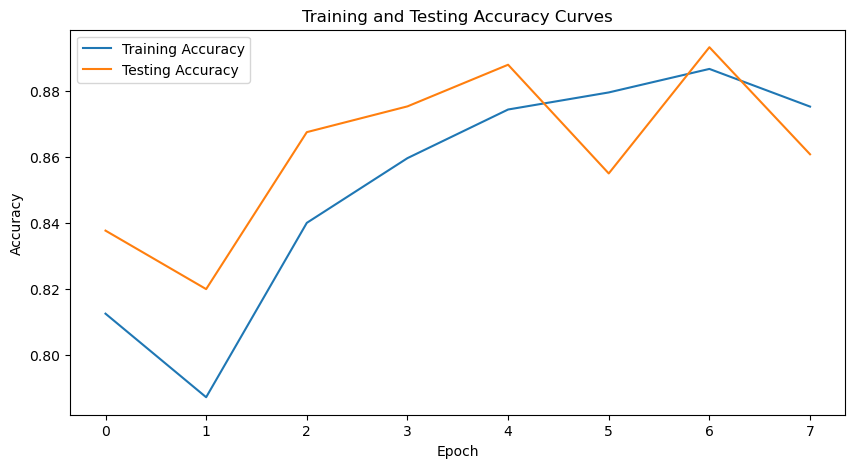

In [40]:
short_hyperparam_run2(num_hidden_units=64, num_layers=1, opt_str='ADAM', rnn_type='gru', learning_rate=1e-3, epochs=8)

Plot the train/test accuracies and the train loss. What do you notice and are the LSTM or GRU better? Also, change the number of hidden units and see how that affects the loss and accuracy.

GRU Hidden Unit Eval

ADAM does not use momentum as a parameter

Epoch 1 of 4
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.466209
Train Epoch: 0	Average Loss: 0.511057	Accuracy: 84.13%
Test Epoch: 0	Average Loss: 0.466017	Accuracy: 85.63%

Epoch 2 of 4
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.584317
Train Epoch: 1	Average Loss: 0.436809	Accuracy: 86.34%
Test Epoch: 1	Average Loss: 0.456275	Accuracy: 86.12%

Epoch 3 of 4
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.320379
Train Epoch: 2	Average Loss: 0.455921	Accuracy: 86.05%
Test Epoch: 2	Average Loss: 0.437561	Accuracy: 85.91%

Epoch 4 of 4
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.523969
Train Epoch: 3	Average Loss: 0.386871	Accuracy: 88.25%
Test Epoch: 3	Average Loss: 0.374401	Accuracy: 88.67%



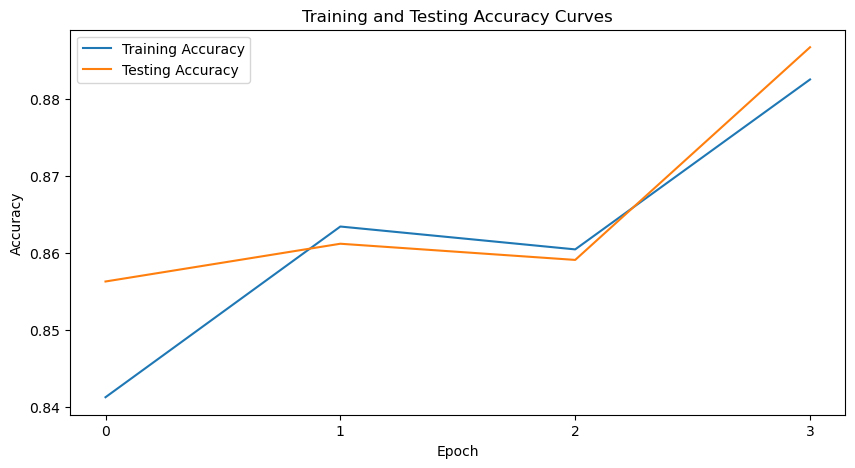

In [36]:
short_hyperparam_run2(num_hidden_units=25, num_layers=1, opt_str='ADAM', rnn_type='gru', learning_rate=1e-3, epochs=4)

ADAM does not use momentum as a parameter

Epoch 1 of 4
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.421867
Train Epoch: 0	Average Loss: 0.366548	Accuracy: 88.77%
Test Epoch: 0	Average Loss: 0.351062	Accuracy: 89.07%

Epoch 2 of 4
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.420608
Train Epoch: 1	Average Loss: 0.458603	Accuracy: 86.01%
Test Epoch: 1	Average Loss: 0.414130	Accuracy: 87.49%

Epoch 3 of 4
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.513984
Train Epoch: 2	Average Loss: 0.386996	Accuracy: 88.21%
Test Epoch: 2	Average Loss: 0.337842	Accuracy: 89.49%

Epoch 4 of 4
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.504011
Train Epoch: 3	Average Loss: 0.377737	Accuracy: 88.42%
Test Epoch: 3	Average Loss: 0.392537	Accuracy: 88.16%



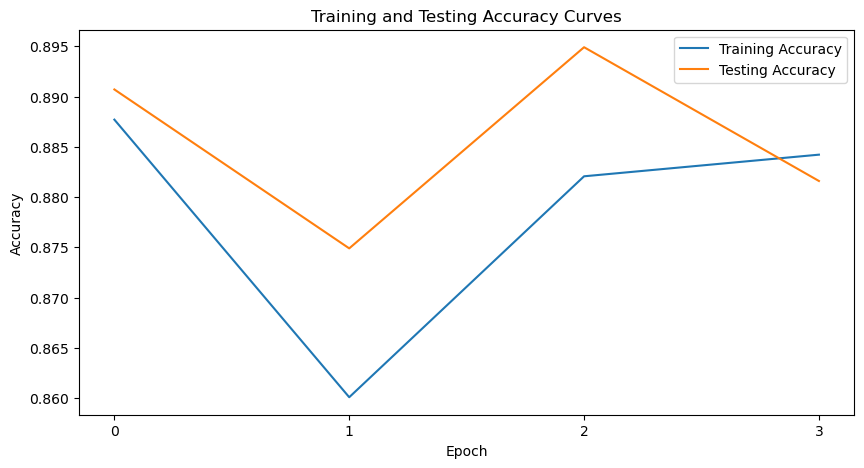

In [37]:
short_hyperparam_run2(num_hidden_units=7, num_layers=1, opt_str='ADAM', rnn_type='gru', learning_rate=1e-3, epochs=4)

LSTM Hidden Unit Eval

ADAM does not use momentum as a parameter

Epoch 1 of 4
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.218429
Train Epoch: 0	Average Loss: 0.357273	Accuracy: 89.15%
Test Epoch: 0	Average Loss: 0.312667	Accuracy: 90.37%

Epoch 2 of 4
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.236834
Train Epoch: 1	Average Loss: 0.342414	Accuracy: 89.61%
Test Epoch: 1	Average Loss: 0.310120	Accuracy: 90.82%

Epoch 3 of 4
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.513053
Train Epoch: 2	Average Loss: 0.351287	Accuracy: 89.50%
Test Epoch: 2	Average Loss: 0.349261	Accuracy: 89.61%

Epoch 4 of 4
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.455707
Train Epoch: 3	Average Loss: 0.341973	Accuracy: 89.70%
Test Epoch: 3	Average Loss: 0.354723	Accuracy: 89.39%



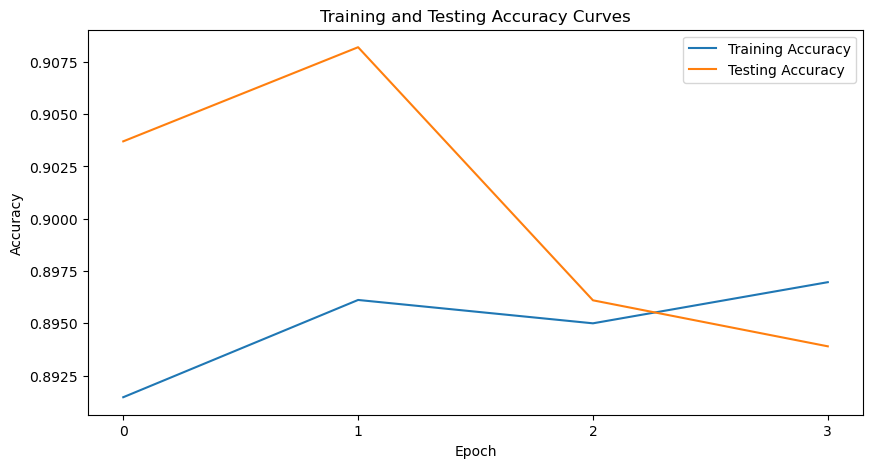

In [38]:
short_hyperparam_run2(num_hidden_units=25, num_layers=1, opt_str='ADAM', rnn_type='lstm', learning_rate=1e-3, epochs=4)

ADAM does not use momentum as a parameter

Epoch 1 of 4
Train Epoch: 0 [29984/60000 (100%)]	Loss: 0.524630
Train Epoch: 0	Average Loss: 0.810024	Accuracy: 74.15%
Test Epoch: 0	Average Loss: 0.625223	Accuracy: 79.84%

Epoch 2 of 4
Train Epoch: 1 [29984/60000 (100%)]	Loss: 0.536236
Train Epoch: 1	Average Loss: 0.646270	Accuracy: 79.48%
Test Epoch: 1	Average Loss: 0.573832	Accuracy: 81.42%

Epoch 3 of 4
Train Epoch: 2 [29984/60000 (100%)]	Loss: 0.494425
Train Epoch: 2	Average Loss: 0.569078	Accuracy: 81.95%
Test Epoch: 2	Average Loss: 0.482028	Accuracy: 84.56%

Epoch 4 of 4
Train Epoch: 3 [29984/60000 (100%)]	Loss: 0.606692
Train Epoch: 3	Average Loss: 0.529951	Accuracy: 83.13%
Test Epoch: 3	Average Loss: 0.548364	Accuracy: 81.95%



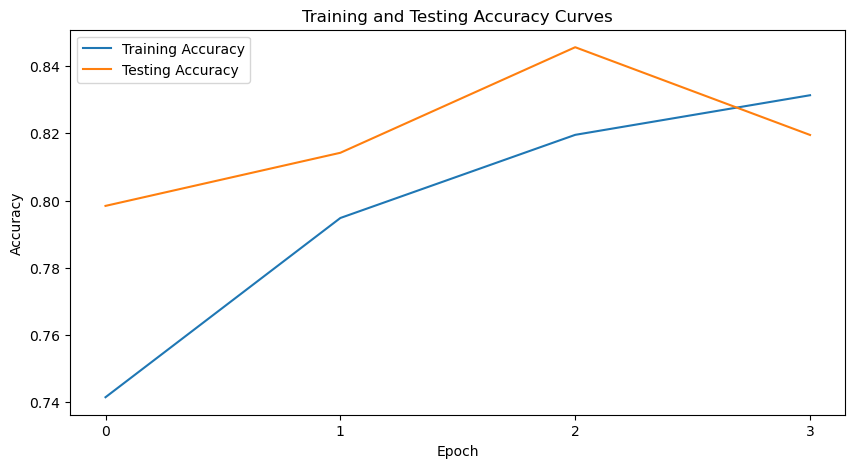

In [39]:
short_hyperparam_run2(num_hidden_units=7, num_layers=1, opt_str='ADAM', rnn_type='lstm', learning_rate=1e-3, epochs=4)

> __Conclusion:__ From the above graphs, it is clear that the LSTM does much worse than the GRU with fewer nodes (with 7 hidden notes, it only gets 80% accuracy). The LSTM outperforms the GRU in the 25 hidden node case, and the 64 hidden node case, which may indicate that LSTMs better utilize all the available expressive power // have better scalability in general.

## 3c Compare against the CNN
> Compare with training using convnet in assignment 1 and describe any similarities or differences.
- The biggest difference is just due to the dataset, since the MNIST dataset is much easier than CIFAR and also faster to train on. The RNN network is much simpler to train (only like 2 lines, or 2 layers) compared to the CNN, in my opinion. I didn't really have to do very much debugging to get it to work, although it seems somewhat less responsive to hyperparameter tuning (must changes resulted in worse performance, albeit only marginally worse so it could be from stochasicity as opposed to the actual params being worse). The biggest difference in my opinion was due to the dataset, which allowed the RNN to train faster, be a simpler network, and achieve much higher performance (90+% as opposed to 60+%), so this wasn't really an apples to apples comparison.